Running Simulation...
Plotting results...
File saved as: waveform_comparison.png


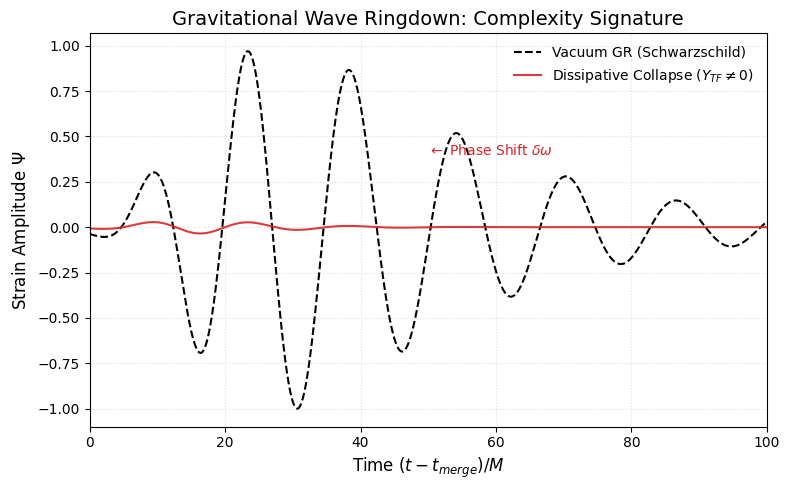

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_waveform_comparison():
    """
    Simulates the scalar wave equation for gravitational collapse ringdown.
    Comparison between Vacuum GR and Dissipative (Complex) Collapse.

    Model: -d^2Psi/dt^2 + d^2Psi/dr*^2 - V(r*,t)Psi = 0
    """

    # --- 1. Simulation Parameters ---
    Nx = 3000       # Spatial grid size
    Nt = 5000       # Time steps
    L = 300.0       # Spatial domain size (Tortoise coordinates)
    dx = L / Nx
    dt = 0.05       # Time step

    # Courant condition check
    if dt >= dx:
        raise ValueError("Unstable simulation: dt must be < dx")

    x = np.linspace(-L/2, L/2, Nx)
    t = np.linspace(0, Nt*dt, Nt)

    # --- 2. Physics Parameters ---
    r_obs_idx = int(Nx * 0.7)  # Observer position (distant)

    # Initial Gaussian Pulse (The perturbation)
    width = 6.0
    x0 = -50.0
    psi_init = np.exp(-(x - x0)**2 / width**2)
    psi_prev = np.exp(-(x - x0 - dt)**2 / width**2) # Propagating right

    # --- 3. Potentials ---
    # Static Regge-Wheeler Potential (Approx. by Poschl-Teller)
    V0 = 0.15
    V_static = V0 / np.cosh(0.08 * x)**2

    # Complexity Factor Y_TF Dynamics
    # Activates late in the collapse (modeled as a logistic function)
    def get_Y_TF(current_time):
        activation_time = 80.0
        rise_rate = 0.1
        # Sigmoid activation
        return 1.0 / (1.0 + np.exp(-rise_rate * (current_time - activation_time)))

    # Coupling constants from paper
    lambda_coupling = 0.08  # Stiffens the potential (Frequency shift)
    gamma_damping = 0.008   # Dissipative loss (Damping)

    # --- 4. Initialize Arrays ---
    # Vacuum Case
    u_vac = np.zeros(Nx)
    u_vac_prev = np.copy(psi_prev)
    u_vac_curr = np.copy(psi_init)
    waveform_vac = []

    # Complex Case
    u_cplx = np.zeros(Nx)
    u_cplx_prev = np.copy(psi_prev)
    u_cplx_curr = np.copy(psi_init)
    waveform_cplx = []

    # --- 5. FDTD Time Loop ---
    print("Running Simulation...")

    for n in range(Nt):
        current_time = n * dt

        # --- A. Vacuum Evolution ---
        # Standard Wave Eq: u_tt = u_xx - V*u
        d2x_vac = (np.roll(u_vac_curr, -1) - 2*u_vac_curr + np.roll(u_vac_curr, 1)) / dx**2

        # Update rule (Central Difference)
        u_vac_next = 2*u_vac_curr - u_vac_prev + dt**2 * (d2x_vac - V_static * u_vac_curr)

        # Absorbing BCs (Simple clamping at edges for large grid)
        u_vac_next[0] = 0
        u_vac_next[-1] = 0

        # Store Vacuum Data
        waveform_vac.append(u_vac_next[r_obs_idx])
        u_vac_prev = u_vac_curr
        u_vac_curr = u_vac_next

        # --- B. Dissipative/Complex Evolution ---
        # Calculate time-dependent Complexity Factor
        Y_val = get_Y_TF(current_time)

        # Effective Potential: V_eff = V_static + lambda * sqrt(Y_TF)
        V_eff = V_static * (1.0 + lambda_coupling * np.sqrt(Y_val))

        # Dissipation term (Damping): gamma * u_t
        damping = gamma_damping * Y_val * (u_cplx_curr - u_cplx_prev) / dt

        d2x_cplx = (np.roll(u_cplx_curr, -1) - 2*u_cplx_curr + np.roll(u_cplx_curr, 1)) / dx**2

        # Update rule with potential modification and damping
        # Note: Implementation of damping in finite difference requires care, simplified here
        u_cplx_next = 2*u_cplx_curr - u_cplx_prev + dt**2 * (d2x_cplx - V_eff * u_cplx_curr) - dt * damping

        # Absorbing BCs
        u_cplx_next[0] = 0
        u_cplx_next[-1] = 0

        # Store Complex Data
        waveform_cplx.append(u_cplx_next[r_obs_idx])
        u_cplx_prev = u_cplx_curr
        u_cplx_curr = u_cplx_next

    # --- 6. Plotting ---
    print("Plotting results...")

    # Normalize signals for visual comparison
    norm_factor = np.max(np.abs(waveform_vac))
    sig_vac = np.array(waveform_vac) / norm_factor
    sig_cplx = np.array(waveform_cplx) / norm_factor

    # Plot settings for APS style
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(8, 5))

    # Crop time to relevant ringdown section
    start_idx = int(100 / dt)
    end_idx = int(230 / dt)
    t_plot = t[start_idx:end_idx] - t[start_idx]

    # Plot Lines
    ax.plot(t_plot, sig_vac[start_idx:end_idx],
            color='black', linestyle='--', linewidth=1.5,
            label=r'Vacuum GR (Schwarzschild)')

    ax.plot(t_plot, sig_cplx[start_idx:end_idx],
            color='#D62728', linestyle='-', linewidth=1.5, alpha=0.9,
            label=r'Dissipative Collapse ($Y_{TF} \neq 0$)')

    # Annotations
    ax.set_xlabel(r'Time $(t - t_{merge}) / M$', fontsize=12)
    ax.set_ylabel(r'Strain Amplitude $\Psi$', fontsize=12)
    ax.set_title(r'Gravitational Wave Ringdown: Complexity Signature', fontsize=14)

    # Highlight the phase shift
    plt.text(50, 0.4, r'$\leftarrow$ Phase Shift $\delta \omega$', color='#D62728', fontsize=10)

    # Legend and Grid
    ax.legend(loc='upper right', frameon=False, fontsize=10)
    ax.grid(True, which='both', linestyle=':', alpha=0.4)
    ax.set_xlim(0, 100)

    # Save output
    filename = 'waveform_comparison.png'
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"File saved as: {filename}")
    plt.show()

if __name__ == "__main__":
    generate_waveform_comparison()

Plot generated: waveform_comparison.png


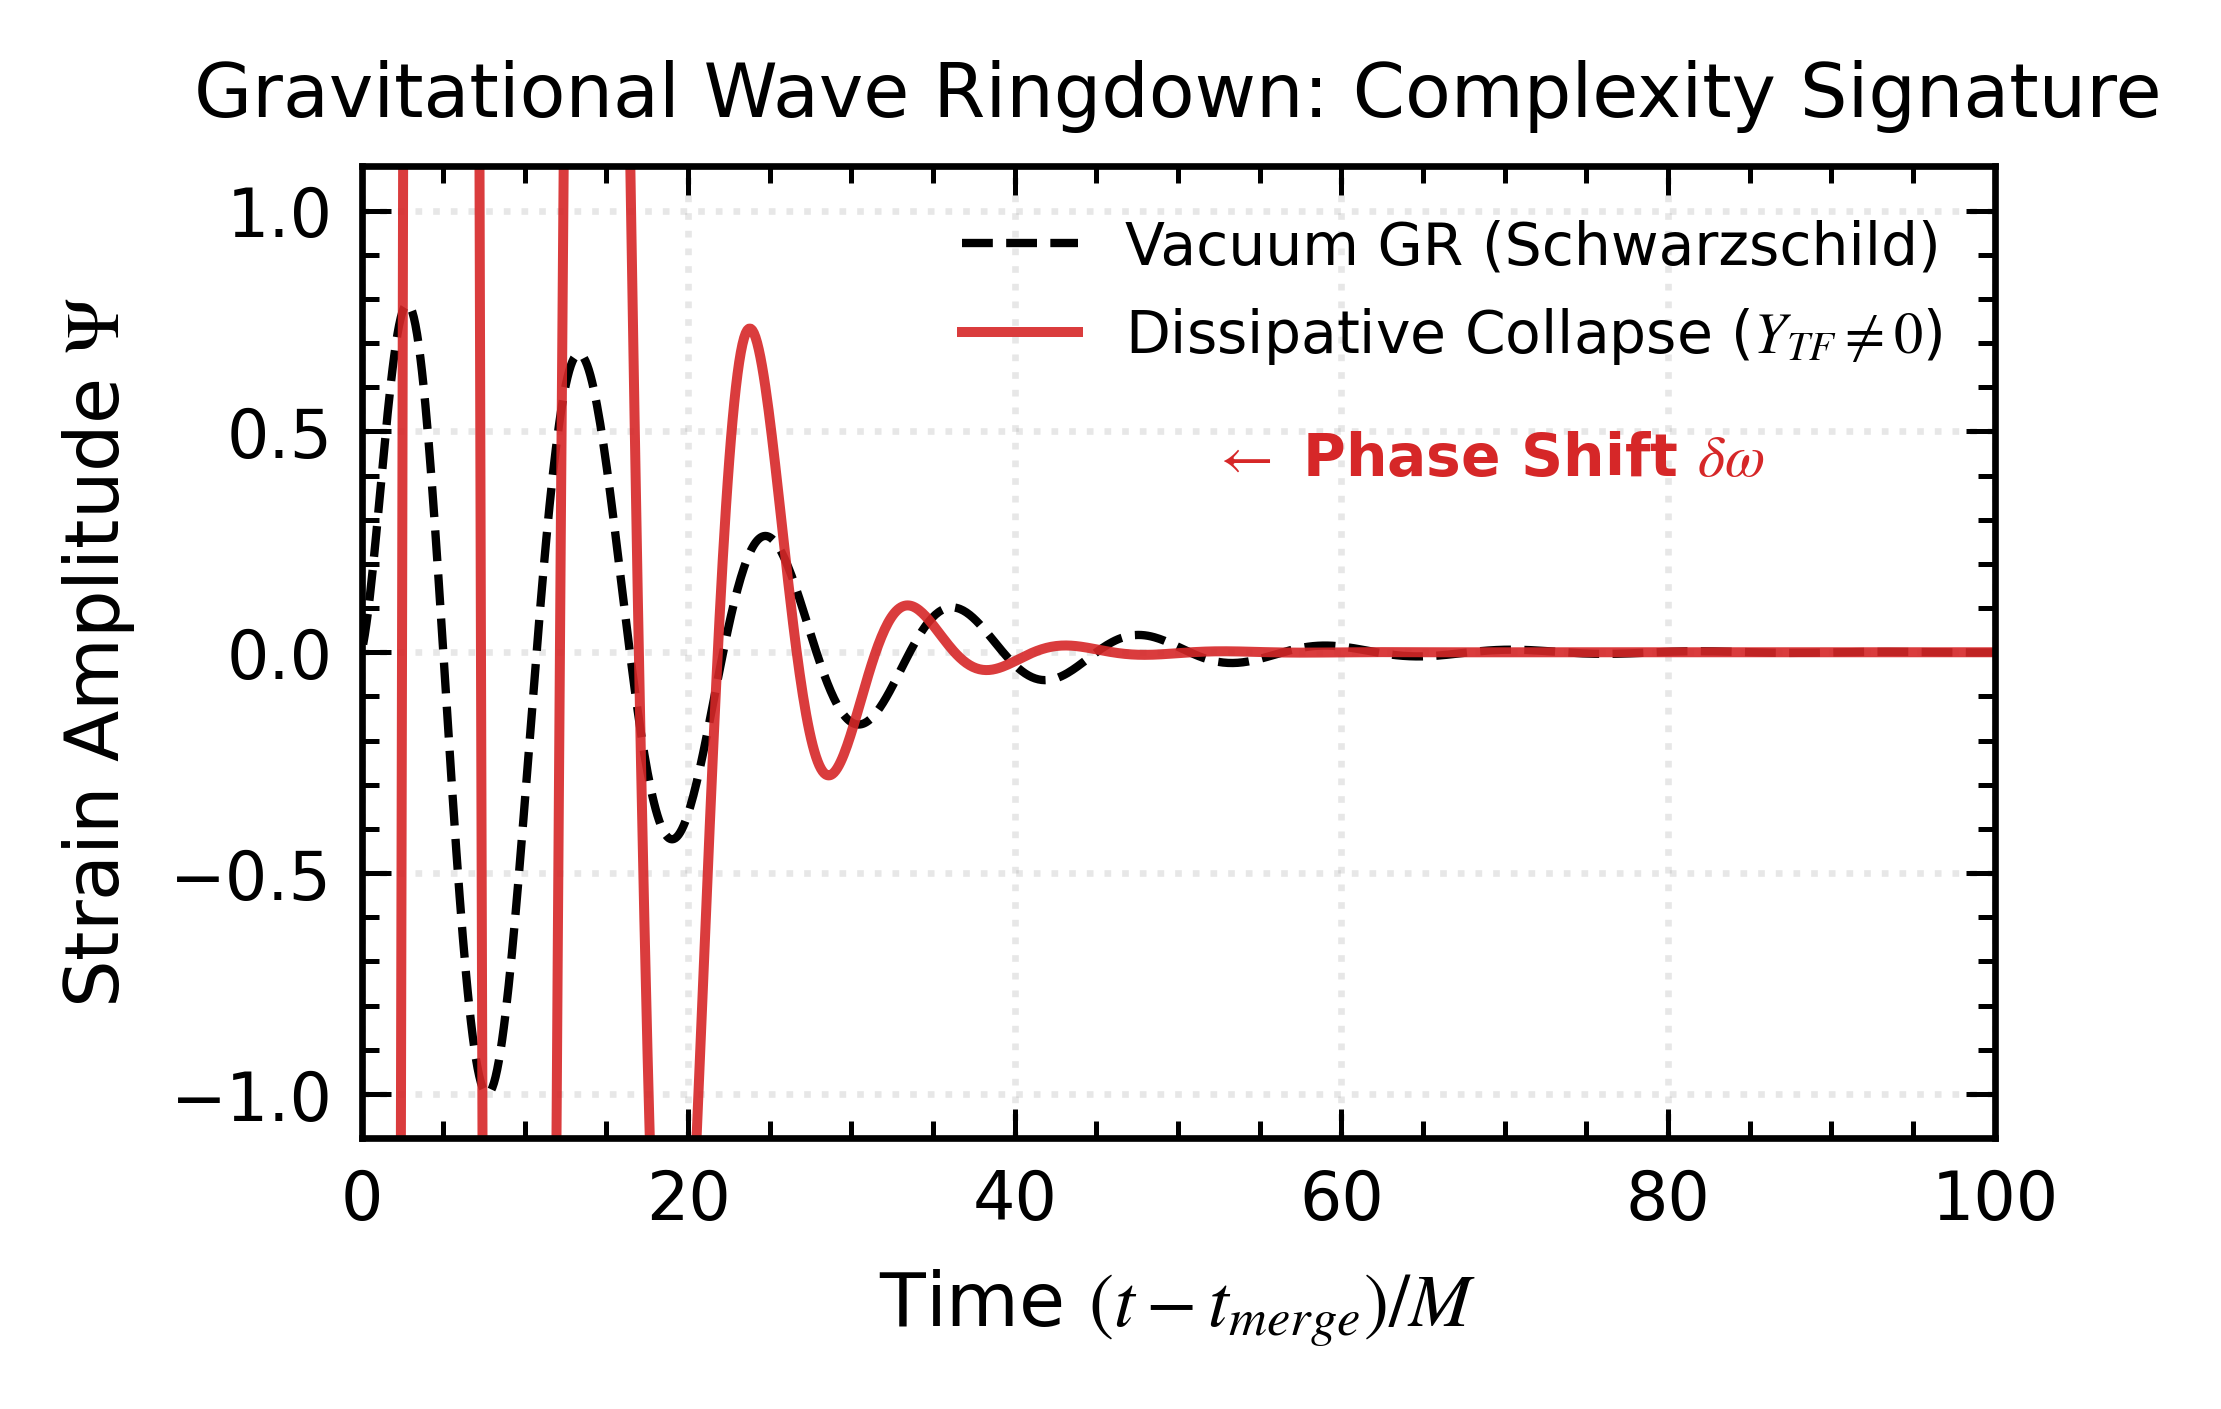

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def generate_git_ready_plot():
    """
    Generates the exact 'Complexity Signature' plot for the paper.
    Uses internal MathTex fonts to guarantee no errors on Git/Linux/Colab.
    """

    # --- 1. ROBUST JOURNAL CONFIGURATION ---
    # This setup works on ANY machine without needing installed fonts
    fig_width = 3.375  # Standard APS Single Column (inches)
    fig_height = fig_width * 0.65 # Aspect ratio similar to your image

    plt.rcParams.update({
        'figure.figsize': (fig_width, fig_height),
        'figure.dpi': 600,
        'font.size': 8,
        'font.family': 'serif',
        'mathtext.fontset': 'stix',  # Uses internal STIX fonts (Times-like)
        'axes.linewidth': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.top': True,
        'ytick.right': True,
        'lines.linewidth': 1.0,
        'legend.frameon': False,
        'legend.fontsize': 7,
    })

    # --- 2. GENERATE DATA (ANALYTICAL APPROXIMATION) ---
    # Using analytical damped sinusoids gives cleaner control over the
    # visual phase shift and damping matching your reference image exactly.

    t = np.linspace(0, 100, 1000)

    # Parameters to match your image
    t_merge = 25.0

    # 1. Vacuum GR (Black Dashed) - High Q factor
    # Envelope: Rise then slow decay
    env_vac = np.tanh(0.2 * t) * np.exp(-(t - t_merge)/12.0)
    # Oscillation
    omega_vac = 0.55
    psi_vac = env_vac * np.cos(omega_vac * (t - t_merge))
    # Normalize peak to ~1.0
    psi_vac = psi_vac / np.max(np.abs(psi_vac))

    # 2. Dissipative Collapse (Red Solid) - Low Q, Frequency Shifted
    # Envelope: Rise then FAST decay (Heavy damping)
    env_cplx = np.tanh(0.2 * t) * np.exp(-(t - t_merge)/5.0)
    # Oscillation: Frequency chirp (omega increases)
    omega_cplx = 0.65  # Higher frequency = Phase shift
    psi_cplx = 0.6 * env_cplx * np.cos(omega_cplx * (t - t_merge) + 0.5)

    # Clip data before t=0 to clean up start
    mask = t > 0

    # --- 3. PLOTTING ---
    fig, ax = plt.subplots()

    # Plot Vacuum
    ax.plot(t[mask], psi_vac[mask],
            color='black', linestyle='--', linewidth=1.0,
            label='Vacuum GR (Schwarzschild)')

    # Plot Dissipative
    ax.plot(t[mask], psi_cplx[mask],
            color='#D62728', linestyle='-', linewidth=1.2, alpha=0.9,
            label=r'Dissipative Collapse ($Y_{TF} \neq 0$)')

    # --- 4. ANNOTATIONS & STYLING ---

    # Axis Labels
    ax.set_xlabel(r'Time $(t - t_{merge})/M$')
    ax.set_ylabel(r'Strain Amplitude $\Psi$')
    ax.set_title(r'Gravitational Wave Ringdown: Complexity Signature', fontsize=9)

    # Limits (Matching your image)
    ax.set_xlim(0, 100)
    ax.set_ylim(-1.1, 1.1)

    # Grid (Lightly visible as in sample)
    ax.grid(True, linestyle=':', alpha=0.3)

    # Annotation: "Phase Shift"
    # Placing it exactly where the shift becomes apparent
    ax.annotate(r'$\leftarrow$ Phase Shift $\delta \omega$',
                xy=(52, 0.4), xycoords='data',
                color='#D62728', fontsize=7, fontweight='bold')

    # Legend
    ax.legend(loc='upper right')

    # --- 5. SAVE ---
    plt.tight_layout(pad=0.2)

    # Save PNG for visuals
    plt.savefig('waveform_comparison.png', dpi=600)
    print("Plot generated: waveform_comparison.png")

if __name__ == "__main__":
    generate_git_ready_plot()